In [1]:
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
import matplotlib.pyplot as plt
import math
import csv
import random

# 导入数据

In [2]:
#文件位置
X_train_fpath = 'hw2_data/X_train.csv'
Y_train_fpath = 'hw2_data/Y_train.csv'
X_test_fpath = 'hw2_data/X_test.csv'
output_fpath = 'hw2_data/预测结果_{}.csv'

#读文件 + 定好数据类型为float
data = pd.read_csv(X_train_fpath)
X_train =data.iloc[:, 1:].to_numpy(dtype = np.float)
data = pd.read_csv(Y_train_fpath)
Y_train =data.iloc[:, 1:].to_numpy(dtype = np.float)
data = pd.read_csv(X_test_fpath)
X_test =data.iloc[:, 1:].to_numpy(dtype = np.float)

# 预处理

In [3]:
eps = 1e-8 #一个非常小的数

In [4]:
def _normalize(X, train = True, specified_column = None, X_mean = None, X_std = None): #归一化
    if specified_column == None: #生成一个数组[0, 1,....,X.shape[1]-1 ]
        specified_column = np.arange(X.shape[1])
    if train:#只有训练集有多列，需要单独算每一列
        X_mean = np.mean(X[:, specified_column] ,0).reshape(1, -1) #算每列的平均值，并把结果形状变成一行
        X_std  = np.std(X[:, specified_column], 0).reshape(1, -1) #算每列的标准差，并把结果形状变成一行
    X[:,specified_column] = (X[:, specified_column] - X_mean) / (X_std + eps)  #归一化 加上eps避免分母為 0
    return X, X_mean, X_std


def _train_dev_split(X, Y, dev_ratio = 0.25):# 将data分成training set 和 development set，输入是 X 和 Y
    train_size = int(len(X) * (1 - dev_ratio))
    return X[:train_size], Y[:train_size], X[train_size:], Y[train_size:]

def _shuffle(X, Y): #按行打乱顺序
    randomize = np.arange(len(X))
    np.random.shuffle(randomize)
    return (X[randomize], Y[randomize])


X_train, X_mean, X_std = _normalize(X_train, train = True)
X_test, _, _= _normalize(X_test, train = False, specified_column = None, X_mean = X_mean, X_std = X_std) #测试集归一化使用的是训练集的均值和标准差

dev_ratio = 0.1
X_train, Y_train, X_dev, Y_dev = _train_dev_split(X_train, Y_train, dev_ratio = dev_ratio) #分成训练集和验证集


train_size = X_train.shape[0]
dev_size = X_dev.shape[0]
test_size = X_test.shape[0]
data_dim = X_train.shape[1]
print('Size of training set: {}'.format(train_size))
print('Size of development set: {}'.format(dev_size))
print('Size of testing set: {}'.format(test_size))
print('data 的维度: {}'.format(data_dim))


Size of training set: 48830
Size of development set: 5426
Size of testing set: 27622
data 的维度: 510


# 概率计算公式
$$ probability = \sigma(z) = {1 \over {1+e^{-z}}} $$    其中：   $$ z = f_{w,b}(x)= \sum_i X_iw_i + b $$

In [5]:
def _sigmoid(z):#算概率
    return np.clip(1 / (1.0 + np.exp(-z)), eps, 1 - eps) 
    #将数组中的元素限制在eps, 1-eps之间，大于1-eps的就使得它等于1-eps，小于eps,的就使得它等于eps

def _f(X, w, b):# 每一行的可能性
    ans = _sigmoid(np.matmul(X, w) + b)
    ans = ans.reshape(-1, 1) #形状变成列向量
    return ans

def _predict(X, w, b): #将结果四舍五入, <0.5为0, >0.5为1
    return np.round(_f(X, w, b)).astype(np.int)

def _accuracy(Y_pred, Y_label):# 算是否准确
    acc = 1 - np.mean(np.abs(Y_pred - Y_label))
    return acc

# 梯度及損失函數計算公式
上課投影片第 12 頁

单个点交叉熵公式：实际上是最大似然值再取对数
$$ cross\_entropy = -\sum^n_{i=1}[\hat y_i lnf_{w,b}(x_i) + (1-\hat y_i) ln(1-f_{w,b}(x_i))] $$
矩阵版交叉熵公式：
$$ cross\_entropy = -[\hat Y lnY + (1-\hat Y)(ln(1 - Y))] $$

In [6]:
def _cross_entropy_loss(y_pred, Y_label): #交叉熵算出来是一个数
    cross_entropy = -np.dot(Y_label.T, np.log(y_pred)) - np.dot((1 - Y_label.T), np.log(1 - y_pred)) #和答案相比转置了Y_label, 
    return cross_entropy[0][0]

def _gradient(X, Y_label, w, b): # 计算交叉熵loss的梯度
    y_pred = _f(X, w, b)
    pred_error = Y_label - y_pred
    #w_grad = -np.sum(pred_error * X.T, 1) #算出来的结果是一条对角线，然后通过求和变成一列
    w_grad = -np.matmul(X.T, pred_error)
    b_grad = -np.sum(pred_error)
    return w_grad, b_grad

# 训练
我們使用小批次梯度下降法來訓練

訓練資料被分為許多小批次，針對每一個小批次，我們分別計算其梯度以及損失，並根據該批次來更新模型的參數

當一次迴圈完成，也就是整個訓練集的所有小批次都被使用過一次以後，我們將所有訓練資料打散並且重新分成新的小批次，進行下一個迴圈，直到事先設定的迴圈數量達成為止

更新参数：
$$ w = w - {learning\_rate \over \sqrt {step}} \times w\_grad $$

$$ b = b - {learning\_rate \over \sqrt {step}} \times b\_grad $$

In [7]:
#初始化
w = np.zeros((data_dim,1)) #修改形状为(data_dim,1), 答案为一维行向量
b = np.zeros((1,1))
max_iter = 50 #整个重复数据集使用的次数
batch_size = 50 #一批训练的数据点个数
learning_rate = 0.2

train_loss = []
dev_loss = []
train_acc = [] #训练集的准确性
dev_acc = [] #验证集的准确性
step = 1 # 降低后面的学习速度

In [8]:
#反复训练
for epoch in range(max_iter): # 打乱顺序
    X_train, Y_train = _shuffle(X_train, Y_train)
        
    # Mini-batch training
    for idx in range(int(np.floor(train_size / batch_size))): #分批
        X = X_train[idx*batch_size : (idx+1)*batch_size]
        Y = Y_train[idx*batch_size : (idx+1)*batch_size]
        w_grad, b_grad = _gradient(X, Y, w, b) #算w和b的梯度
        w = w - learning_rate/np.sqrt(step) * w_grad #更新
        b = b - learning_rate/np.sqrt(step) * b_grad

        step = step + 1
    
    #一轮完成后
    y_train_pred = _f(X_train, w, b) #算预测的值
    Y_train_pred = np.round(y_train_pred) #将结果四舍五入, <0.5为0, >0.5为1
    train_acc.append(_accuracy(Y_train_pred, Y_train)) #计算准确率
    train_loss.append((_cross_entropy_loss(y_train_pred, Y_train) / train_size)) #@计算loss

    #验证
    y_dev_pred = _f(X_dev, w, b)
    Y_dev_pred = np.round(y_dev_pred)
    dev_acc.append(_accuracy(Y_dev_pred, Y_dev))
    dev_loss.append((_cross_entropy_loss(y_dev_pred, Y_dev) / dev_size))

print('Training loss: {}'.format(train_loss[-1]))
print('Development loss: {}'.format(dev_loss[-1]))
print('Training accuracy: {}'.format(train_acc[-1]))
print('Development accuracy: {}'.format(dev_acc[-1]))


<ipython-input-5-f47562a31edd>:2: RuntimeWarning: overflow encountered in exp
  return np.clip(1 / (1.0 + np.exp(-z)), eps, 1 - eps)


Training loss: 0.2711004479441347
Development loss: 0.29306385896642395
Training accuracy: 0.8842924431701823
Development accuracy: 0.875783265757464


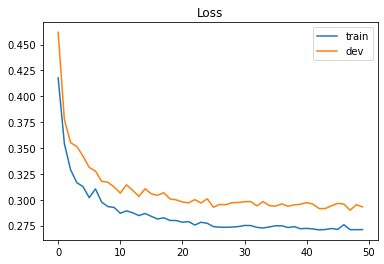

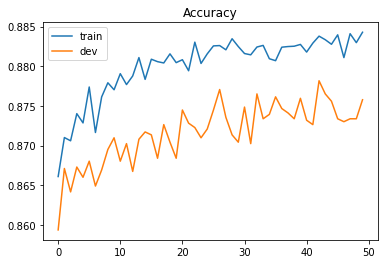

In [9]:
import matplotlib.pyplot as plt

# Loss curve
plt.plot(train_loss)
plt.plot(dev_loss)
plt.title('Loss')
plt.legend(['train', 'dev'])
#plt.savefig('loss.png')
plt.show()

# Accuracy curve
plt.plot(train_acc)
plt.plot(dev_acc)
plt.title('Accuracy')
plt.legend(['train', 'dev'])
#plt.savefig('acc.png')
plt.show()

# 預測測試集的資料標籤

In [10]:
# Predict testing labels
predictions = _predict(X_test, w, b)
with open(output_fpath.format('逻辑分类'), 'w') as f:
    f.write('id,label\n')
    for i, label in  enumerate(predictions):
        f.write('{},{}\n'.format(i, label[0]))

# Print out the most significant weights
w1 = w.reshape(w.shape[0])
ind = np.argsort(np.abs(w1))[::-1]
with open(X_test_fpath) as f:
    content = f.readline().strip('\n').split(',')
features = np.array(content)
for i in ind[0:10]:
    print(features[i], w[i][0])

 Local government -3.3957183161235873
2 -2.730023319039957
 High school graduate -2.726068616443432
 No 2.3094500480913918
 Vietnam -2.254034736333589
num persons worked for employer 1.9117001527546935
 Other Rel 18+ ever marr RP of subfamily -1.8675257814535973
 Grandchild 18+ ever marr not in subfamily -1.8524454926267169
 Grandchild 18+ never marr RP of subfamily -1.766864876936216
 Child under 18 ever married -1.766059177411513


<ipython-input-5-f47562a31edd>:2: RuntimeWarning: overflow encountered in exp
  return np.clip(1 / (1.0 + np.exp(-z)), eps, 1 - eps)
